In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from math import ceil
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, root_mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import time

import warnings
warnings.filterwarnings('ignore')

from functions_MARISA import *
from Classes import Categorical_Correction, Outlier_Treatment, Missing_Value_Treatment, Typecasting, Feature_Engineering, Encoder, Scaler, Feature_Selection

In [15]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [16]:
df_train.set_index('carID', inplace=True)
df_test.set_index('carID', inplace=True)

In [17]:
random_state = 42

## Pre-Processing

We start by defining the inconsistent values discussed in the EDA as NA:

In [18]:
df_train.loc[df_train['year']>2020, 'year'] = np.nan
df_test.loc[df_test['year']>2020, 'year'] = np.nan

df_train.loc[df_train['mileage']<0, 'mileage'] = np.nan
df_test.loc[df_test['mileage']<0, 'mileage'] = np.nan

df_train.loc[df_train['tax']<0, 'tax'] = np.nan
df_test.loc[df_test['tax']<0,'tax'] = np.nan

df_train.loc[df_train['mpg']<=0, 'mpg'] = np.nan
df_test.loc[df_test['mpg']<=0, 'mpg'] = np.nan


df_train.loc[df_train['previousOwners']< 0, 'previousOwners'] = np.nan
df_test.loc[df_test['previousOwners']< 0, 'previousOwners'] = np.nan

df_train.loc[df_train['engineSize']<= 0, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize']<= 0, 'engineSize'] = np.nan

df_train.loc[df_train['mpg'] < 8, 'mpg'] = np.nan
df_test.loc[df_test['mpg'] < 8, 'mpg'] = np.nan

df_train.loc[df_train['engineSize'] < 1, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize'] < 1, 'engineSize'] = np.nan

We proceed to round 'year' and 'previousOwners' to whole numbers using the floor function. Other numerical features are rounded to 2 decimal points.

In [19]:
df_train['year'] = np.floor(df_train['year'])
df_train['previousOwners'] = np.floor(df_train['previousOwners'])

df_test['year'] = np.floor(df_test['year'])
df_test['previousOwners'] = np.floor(df_test['previousOwners'])

for feat in ['mileage', 'tax', 'mpg', 'engineSize']:
    df_train[feat] = df_train[feat].round(2)
    df_test[feat] = df_test[feat].round(2)

We also pre-process the categorical variables in order to have a uniform format for later treatment (inside k-fold CV). We remove leeading and trailing spaces and uppercase all letters.

In [20]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())

In [21]:
(df_train["price"] == 0).any()

np.False_

In [22]:
y = df_train['price']
X = df_train.drop('price', axis=1)

In [23]:
X.drop('paintQuality%', axis=1, inplace=True)
df_test.drop('paintQuality%', axis=1, inplace=True)

Notas sobre as classes:

- variáveis criadas na inicialização não acabam em _; as ue são criadas dentro dos métodos acabam em _!
- criando uma var nos métodos, se ela não começar em self. não será reconhecida por toda a classe, será apenas local!
- logo, iniciar com self. para criar novos atributos gerais (assim transform() cconsegue aceder ao atributo criado em fit() por exemplo)
- cuidado com data leakage! :D

### Categorical_Correction Class

### PIPELINE

In [24]:
pipeline_huber = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), #NO NEED FOR RANDOM FOREST REG
    ('feature selection', Feature_Selection()),
    ('regressor', HuberRegressor())
])

pipeline_huber_logprice = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=HuberRegressor(), func=np.log, inverse_func=np.exp))
])




pipeline_mlp = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), transformer = StandardScaler()))
])

pipeline_mlp_logprice = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log, inverse_func=np.exp))
])

pipeline_mlp_robust = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(RobustScaler())),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), transformer = StandardScaler()))
])

pipeline_mlp_robust_logprice = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(RobustScaler())),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log, inverse_func=np.exp))
])

pipeline_mlp_minmax = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(MinMaxScaler())),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), transformer = StandardScaler()))
])

pipeline_mlp_minmax_logprice = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(MinMaxScaler())),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log, inverse_func=np.exp))
])

pipeline_mlp_minmax2 = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(MinMaxScaler( feature_range=(-1,1)))),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), transformer = StandardScaler()))
])

pipeline_mlp_minmax2_logprice = Pipeline([
    ('categorical treatment', Categorical_Correction()),
    ('outlier treatment', Outlier_Treatment()),
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()),
    ('feature engineering', Feature_Engineering()),
    ('encoder', Encoder() ),
    ('scaler', Scaler(MinMaxScaler( feature_range=(-1,1)))),
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log, inverse_func=np.exp))
])

### Random Search

In [25]:
# Making an adjusted R2 function:

def adjusted_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) # erros

adj_r2 = make_scorer(adjusted_r2_scorer, greater_is_better=True) #erros


scoring = { 'R2': 'r2', #'AdjR2': adj_r2 -> esta função é difícil de implementar, erros
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MedAE': 'neg_median_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'}




In [ ]:
param_distributions_huber = {
    'regressor__epsilon': [1.1, 1.2, 1.35, 1.5, 2.0, 2.5, 3.0],
    'regressor__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0],
    'regressor__fit_intercept': [True],
    'regressor__max_iter': [500, 1000, 2000]

}

param_distributions_huber_logprice = {
    'regressor__regressor__epsilon': [1.1, 1.2, 1.35, 1.5, 2.0, 2.5, 3.0],
    'regressor__regressor__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0],
    'regressor__regressor__fit_intercept': [True],
    'regressor__regressor__max_iter': [500, 1000, 2000]

}


param_distributions_mlp_adam = {
    'regressor__regressor__solver' : ['adam'],
    'regressor__regressor__hidden_layer_sizes' : [(32,16), (200, 100), (400, 200), (100,50,25)],
    'regressor__regressor__max_iter' :  [700],
    'regressor__regressor__activation' : ['relu', 'tanh', 'logistic'],
    'regressor__regressor__learning_rate_init' : [0.001, 0.01, 0.1],
    'feature selection__rfe_k': list(range(1,15)),
    'feature selection__spearman_thr': [0.2, 0.25, 0.3],
    
}

param_distributions_mlp_sgd = { 
    'regressor__regressor__solver' : ['sgd'],
    'regressor__regressor__hidden_layer_sizes' : [(32,16),(100,50), (200,100), (100,50,25), (200,100,50)],
    'regressor__regressor__max_iter' :  [700],
    'regressor__regressor__activation' : ['relu', 'tanh', 'logistic'],
    'regressor__regressor__learning_rate' :  ['constant','invscaling','adaptive'],
    'regressor__regressor__learning_rate_init' : [0.01, 0.001, 0.0001, 0.00001],
    'regressor__regressor__batch_size' : [100, 200, 500],
    'regressor__regressor__alpha': [1e-6, 1e-5, 1e-4, 1e-3],
    'feature selection__rfe_k': list(range(1,23)),
    'feature selection__spearman_thr': [0.2, 0.25, 0.3]
}

param_distributions_mlp_adam_logprice = {
    'regressor__regressor__solver' : ['adam'],
    'regressor__regressor__hidden_layer_sizes' : [(32,16), (200, 100), (600, 200), (400,200,100), (300,200,100), (200,100,50), (100,50,25), (600,300,150)],
    'regressor__regressor__max_iter' :  [700],
    'regressor__regressor__activation' : ['relu', 'tanh', 'logistic'],
    'regressor__regressor__learning_rate_init' : [0.0001, 0.001, 0.01, 0.1],
    'feature selection__rfe_k': list(range(1,23)),
    'feature selection__spearman_thr': [0.2, 0.25, 0.3]
    
}

param_distributions_mlp_sgd_logprice = { 
    'regressor__regressor__solver' : ['sgd'],
    'regressor__regressor__hidden_layer_sizes' : [(32,16), (100,50),(200,100), (100,50,25), (200,100,50)],
    'regressor__regressor__max_iter' :  [700],
    'regressor__regressor__activation' : ['relu', 'tanh', 'logistic'],
    'regressor__regressor__learning_rate' :  ['constant','invscaling','adaptive'],
    'regressor__regressor__learning_rate_init' : [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'regressor__regressor__batch_size' : [100, 200, 500],
    'regressor__regressor__alpha': [1e-6, 1e-5, 1e-4, 1e-3],
    'feature selection__rfe_k': list(range(1,23)),
    'feature selection__spearman_thr': [0.2, 0.25, 0.3],
}



def random_search (pipeline, param_distributions, n_iter=10) :
    return RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,             # 10 random combinations of parameters -> reduced to 2 just for testing
        scoring=scoring, # evaluation metrics
        refit = 'MAE',
        cv=KFold(n_splits=5, shuffle=True, random_state=random_state),                 # 10-fold CV -> mudei para 5 
        verbose=3, # to show iterations
        return_train_score=True, # to return train metric results in cv_scores_
        random_state=random_state, # defined on top of the nb
        n_jobs=-1 
    )

rs_huber = random_search(
    pipeline=pipeline_huber,
    param_distributions=param_distributions_huber)

rs_huber_logprice = random_search(
    pipeline=pipeline_huber_logprice,
    param_distributions=param_distributions_huber_logprice)

rs_mlp_adam = random_search(pipeline = pipeline_mlp, param_distributions=param_distributions_mlp_adam, n_iter=30)
rs_mlp_adam_logprice = random_search(pipeline = pipeline_mlp_logprice, param_distributions=param_distributions_mlp_adam_logprice, n_iter=30)
rs_mlp_adam_robust = random_search(pipeline = pipeline_mlp_robust, param_distributions=param_distributions_mlp_adam, n_iter=30)
rs_mlp_adam_robust_logprice = random_search(pipeline = pipeline_mlp_robust_logprice, param_distributions=param_distributions_mlp_adam_logprice, n_iter=30)
rs_mlp_adam_minmax = random_search(pipeline = pipeline_mlp_minmax, param_distributions=param_distributions_mlp_adam, n_iter=30)
rs_mlp_adam_minmax_logprice = random_search(pipeline = pipeline_mlp_minmax_logprice, param_distributions=param_distributions_mlp_adam_logprice, n_iter=30)
rs_mlp_adam_minmax2 = random_search(pipeline = pipeline_mlp_minmax2, param_distributions = param_distributions_mlp_adam, n_iter=30)
rs_mlp_adam_minmax2_logprice = random_search(pipeline = pipeline_mlp_minmax2_logprice, param_distributions = param_distributions_mlp_adam_logprice, n_iter=30)

rs_mlp_sgd = random_search(pipeline = pipeline_mlp, param_distributions=param_distributions_mlp_sgd, n_iter=30)
rs_mlp_sgd_logprice = random_search(pipeline = pipeline_mlp_logprice, param_distributions=param_distributions_mlp_sgd_logprice, n_iter=30)
rs_mlp_sgd_robust = random_search(pipeline = pipeline_mlp_robust, param_distributions=param_distributions_mlp_sgd, n_iter=30)
rs_mlp_sgd_robust_logprice = random_search(pipeline = pipeline_mlp_robust_logprice, param_distributions=param_distributions_mlp_sgd_logprice, n_iter=30)
rs_mlp_sgd_minmax = random_search(pipeline = pipeline_mlp_minmax, param_distributions=param_distributions_mlp_sgd, n_iter=30)
rs_mlp_sgd_minmax_logprice = random_search(pipeline = pipeline_mlp_minmax_logprice, param_distributions=param_distributions_mlp_sgd_logprice, n_iter=30)
rs_mlp_sgd_minmax2 = random_search(pipeline = pipeline_mlp_minmax2, param_distributions = param_distributions_mlp_sgd, n_iter=30)
rs_mlp_sgd_minmax2_logprice = random_search(pipeline = pipeline_mlp_minmax2_logprice, param_distributions = param_distributions_mlp_sgd_logprice, n_iter=30)


### Running RnadomizedSearchCV

In [28]:
for rs in [rs_mlp_adam, rs_mlp_sgd, rs_mlp_adam_robust, rs_mlp_sgd_robust, rs_mlp_adam_minmax, rs_mlp_sgd_minmax, rs_mlp_adam_minmax2, rs_mlp_sgd_minmax2]:
    print("Running RandomizedSearchCV with Pipeline with MLP...")
    rs.fit(X, y)

    print("\nRandomizedSearchCV Results:")
    print(f"Best parameters: {rs.best_params_}")
    print(f"Best CV score: {rs.best_score_:.4f}")
    idx = rs.best_index_
    train_mae = rs.cv_results_["mean_train_MAE"][idx]
    overfit = (rs.best_score_ - train_mae) / abs(train_mae) * 100
    print(f"Overfit: {overfit:.2f}%\n\n")
    print(f' Number of iterations until convergence : {rs.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Running RandomizedSearchCV with Pipeline with MLP...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'adam', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.001, 'regressor__regressor__hidden_layer_sizes': (600, 200), 'regressor__regressor__activation': 'relu'}
Best CV score: -1615.5530
Overfit: -12.47%


 Number of iterations until convergence : 144
Running RandomizedSearchCV with Pipeline with MLP...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'sgd', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.01, 'regressor__regressor__learning_rate': 'adaptive', 'regressor__regressor__hidden_layer_sizes': (32, 16), 'regressor__regressor__batch_size': 200, 'regressor__regressor__alpha': 1e-06, 'regressor__regressor__activation': 'relu'}

SEM LOG:
Para adam a melhor opção sem overfit é robust scaler LR = 0.001, (200,100,50), relu. MAE -> 1639. Overfit -> 8.28 Nao vale a pena mexer nos parametros.
Para standarscaler dá melhor mas dá overfit com (600,200), experimentar substituir isso por (400,200) e voltar a correr

Para sgd o melhor é Standardscaler LR=0.01, lr 0 ADAPTIVE, (32,16), BATCH = 200, relu. MAE -> 1770, overfit -> 2.20



COM LOG:
Para adam o melhor é standarscaler, 0.001, (200,100,50), tahn. MAE -> 1962. Overfit -> 3% Experimentar aumentar complexidade !!
Para sgd o melhor é MinMax com 0.1, adaptive, (200,100) batchsize = 200,, relu. MAE -> 1820. Overfit -> 1.49

In [29]:
for rs in [rs_mlp_adam_logprice, rs_mlp_sgd_logprice, rs_mlp_adam_robust_logprice, rs_mlp_sgd_robust_logprice, rs_mlp_adam_minmax_logprice, rs_mlp_sgd_minmax_logprice, rs_mlp_adam_minmax2_logprice, rs_mlp_sgd_minmax2_logprice]:
    print("Running RandomizedSearchCV with Pipeline with MLP and Log Price...")
    rs.fit(X, y)

    print("\nRandomizedSearchCV Results:")
    print(f"Best parameters: {rs.best_params_}")
    print(f"Best CV score: {rs.best_score_:.4f}")
    idx = rs.best_index_
    train_mae = rs.cv_results_["mean_train_MAE"][idx]
    overfit = (rs.best_score_ - train_mae) / abs(train_mae) * 100
    print(f"Overfit: {overfit:.2f}%\n\n")
    print(f' Number of iterations until convergence : {rs.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')


Running RandomizedSearchCV with Pipeline with MLP and Log Price...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'adam', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.001, 'regressor__regressor__hidden_layer_sizes': (200, 100, 50), 'regressor__regressor__activation': 'tanh'}
Best CV score: -1692.3330
Overfit: -3.02%


 Number of iterations until convergence : 68
Running RandomizedSearchCV with Pipeline with MLP and Log Price...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'sgd', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.01, 'regressor__regressor__learning_rate': 'adaptive', 'regressor__regressor__hidden_layer_sizes': (32, 16), 'regressor__regressor__batch_size': 100, 'regressor__regressor__alpha': 0.001, 'regressor__r

In [27]:
print("Running RandomizedSearchCV with Pipeline with MLP and Log Price, StandardScaler...")
rs_mlp_adam_logprice.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {rs_mlp_adam_logprice.best_params_}")
print(f"Best CV score: {rs_mlp_adam_logprice.best_score_:.4f}")
idx = rs_mlp_adam_logprice.best_index_
train_mae = rs_mlp_adam_logprice.cv_results_["mean_train_MAE"][idx]
overfit = (rs_mlp_adam_logprice.best_score_ - train_mae) / abs(train_mae) * 100
print(f"Overfit: {overfit:.2f}%\n\n")
print(f' Number of iterations until convergence : {rs_mlp_adam_logprice.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Running RandomizedSearchCV with Pipeline with MLP and Log Price, StandardScaler...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'adam', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.0001, 'regressor__regressor__hidden_layer_sizes': (600, 300, 150), 'regressor__regressor__activation': 'relu', 'feature selection__spearman_thr': 0.2, 'feature selection__rfe_k': 14}
Best CV score: -1609.5665
Overfit: -7.10%


 Number of iterations until convergence : 82


In [28]:
print("Running RandomizedSearchCV with Pipeline with MLP, StandardScaler...")
rs_mlp_adam.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {rs_mlp_adam.best_params_}")
print(f"Best CV score: {rs_mlp_adam.best_score_:.4f}")
idx = rs_mlp_adam.best_index_
train_mae = rs_mlp_adam.cv_results_["mean_train_MAE"][idx]
overfit = (rs_mlp_adam.best_score_ - train_mae) / abs(train_mae) * 100
print(f"Overfit: {overfit:.2f}%\n\n")
print(f' Number of iterations until convergence : {rs_mlp_adam.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Running RandomizedSearchCV with Pipeline with MLP, StandardScaler...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'adam', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.001, 'regressor__regressor__hidden_layer_sizes': (200, 100), 'regressor__regressor__activation': 'relu', 'feature selection__spearman_thr': 0.2, 'feature selection__rfe_k': 20}
Best CV score: -1488.7886
Overfit: -15.41%


 Number of iterations until convergence : 105


In [29]:
print("Running RandomizedSearchCV with Pipeline with MLP, StandardScaler...")
rs_mlp_sgd.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {rs_mlp_sgd.best_params_}")
print(f"Best CV score: {rs_mlp_sgd.best_score_:.4f}")
idx = rs_mlp_sgd.best_index_
train_mae = rs_mlp_sgd.cv_results_["mean_train_MAE"][idx]
overfit = (rs_mlp_sgd.best_score_ - train_mae) / abs(train_mae) * 100
print(f"Overfit: {overfit:.2f}%\n\n")
print(f' Number of iterations until convergence : {rs_mlp_sgd.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Running RandomizedSearchCV with Pipeline with MLP, StandardScaler...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'sgd', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.01, 'regressor__regressor__learning_rate': 'adaptive', 'regressor__regressor__hidden_layer_sizes': (100, 50), 'regressor__regressor__batch_size': 100, 'regressor__regressor__alpha': 1e-06, 'regressor__regressor__activation': 'relu', 'feature selection__spearman_thr': 0.2, 'feature selection__rfe_k': 11}
Best CV score: -1512.9584
Overfit: -4.13%


 Number of iterations until convergence : 176


In [30]:
print("Running RandomizedSearchCV with Pipeline with MLP and Log Price, StandardScaler...")
rs_mlp_sgd_minmax_logprice.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {rs_mlp_sgd_minmax_logprice.best_params_}")
print(f"Best CV score: {rs_mlp_sgd_minmax_logprice.best_score_:.4f}")
idx = rs_mlp_sgd_minmax_logprice.best_index_
train_mae = rs_mlp_sgd_minmax_logprice.cv_results_["mean_train_MAE"][idx]
overfit = (rs_mlp_sgd_minmax_logprice.best_score_ - train_mae) / abs(train_mae) * 100
print(f"Overfit: {overfit:.2f}%\n\n")
print(f' Number of iterations until convergence : {rs_mlp_sgd_minmax_logprice.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Running RandomizedSearchCV with Pipeline with MLP and Log Price, StandardScaler...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__regressor__solver': 'sgd', 'regressor__regressor__max_iter': 700, 'regressor__regressor__learning_rate_init': 0.01, 'regressor__regressor__learning_rate': 'adaptive', 'regressor__regressor__hidden_layer_sizes': (200, 100), 'regressor__regressor__batch_size': 500, 'regressor__regressor__alpha': 0.001, 'regressor__regressor__activation': 'relu', 'feature selection__spearman_thr': 0.3, 'feature selection__rfe_k': 21}
Best CV score: -1985.1100
Overfit: -0.56%


 Number of iterations until convergence : 96


In [34]:
param_distribution_sgd_teste = {'regressor__regressor__solver': ['sgd'], 'regressor__regressor__max_iter': [300], 'regressor__regressor__learning_rate_init': [0.01], 'regressor__regressor__learning_rate': ['adaptive'], 'regressor__regressor__hidden_layer_sizes': [(200,100)], 'regressor__regressor__batch_size': [100], 'regressor__regressor__alpha': [1e-06], 'regressor__regressor__activation': ['relu'], 'feature selection__spearman_thr': [0.2], 'feature selection__rfe_k': [11]}
rs_mlp_sgd = random_search(pipeline = pipeline_mlp, param_distributions=param_distribution_sgd_teste, n_iter=1)
rs_mlp_sgd.fit(X, y)
print(f"Best parameters: {rs_mlp_sgd.best_params_}")
print(f"Best CV score: {rs_mlp_sgd.best_score_:.4f}")
idx = rs_mlp_sgd.best_index_
train_mae = rs_mlp_sgd.cv_results_["mean_train_MAE"][idx]
overfit = (rs_mlp_sgd.best_score_ - train_mae) / abs(train_mae) * 100
print(f"Overfit: {overfit:.2f}%\n\n")
print(f' Number of iterations until convergence : {rs_mlp_sgd.best_estimator_.named_steps["regressor"].regressor_.n_iter_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'regressor__regressor__solver': 'sgd', 'regressor__regressor__max_iter': 300, 'regressor__regressor__learning_rate_init': 0.01, 'regressor__regressor__learning_rate': 'adaptive', 'regressor__regressor__hidden_layer_sizes': (200, 100), 'regressor__regressor__batch_size': 100, 'regressor__regressor__alpha': 1e-06, 'regressor__regressor__activation': 'relu', 'feature selection__spearman_thr': 0.2, 'feature selection__rfe_k': 11}
Best CV score: -1461.8309
Overfit: -6.26%


 Number of iterations until convergence : 219


In [17]:
rs_mlp_adam.best_estimator_.named_steps['feature selection'].selected_features_

['year',
 'mileage',
 'mpg',
 'engineSize',
 'carAge',
 'carSegment',
 'model_cleaned_encoded',
 'Brand_cleaned_encoded',
 'fuelType_cleaned_DIESEL',
 'transmission_cleaned_MANUAL']

In [34]:
import joblib

joblib.dump(rs_teste.best_estimator_, "modelo_mlp_teste.pkl")

['modelo_mlp_teste.pkl']

In [ ]:
best_pipeline = rs_mlp_adam.best_estimator_
selector = best_pipeline.named_steps['feature selection']

# Máscara de features selecionadas pelo fit no treino completo
selected_mask = selector.best_
selected_mask



{'features': ['year',
  'mileage',
  'tax',
  'engineSize',
  'carAge',
  'AvgUsage',
  'carSegment',
  'model_cleaned_encoded',
  'Brand_cleaned_encoded',
  'fuelType_cleaned_DIESEL',
  'fuelType_cleaned_PETROL',
  'transmission_cleaned_AUTOMATIC',
  'transmission_cleaned_MANUAL'],
 'mae': 2623.6985387785553}

In [ ]:
results_df = {}
df_metrics = {}

for rs in random_searches:
    results_df[f'results_{rs}'] = pd.DataFrame(rs.cv_results_)


    metric_cols_train_R2 = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_train_R2")]
    metric_cols_test_R2 = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_test_R2")]

    metric_cols_train_MAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_train_MAE")]
    metric_cols_test_MAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_test_MAE")]
    metric_cols_train_MAPE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_train_MAPE")]
    metric_cols_test_MAPE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_test_MAPE")]
    metric_cols_train_MedAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_train_MedAE")]
    metric_cols_test_MedAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_test_MedAE")]
    metric_cols_train_RMSE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_train_RMSE")]
    metric_cols_test_RMSE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("mean_test_RMSE")]

    std_cols_train_R2 = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_train_R2")]
    std_cols_test_R2 = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_test_R2")]

    std_cols_train_MAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_train_MAE")]
    std_cols_test_MAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_test_MAE")]
    std_cols_train_MAPE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_train_MAPE")]
    std_cols_test_MAPE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_test_MAPE")]
    std_cols_train_MedAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_train_MedAE")]
    std_cols_test_MedAE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_test_MedAE")]
    std_cols_train_RMSE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_train_RMSE")]
    std_cols_test_RMSE = [c for c in results_df[f'results_{rs}'].columns if c.startswith("std_test_RMSE")]


    df_metrics[f'{rs}'] = results_df[f'results_{rs}'][["params"]+ metric_cols_train_MAE + metric_cols_test_MAE +
                        metric_cols_train_R2 + metric_cols_test_R2 + 
                        metric_cols_train_MAPE + metric_cols_test_MAPE + 
                        metric_cols_train_MedAE + metric_cols_test_MedAE + 
                        metric_cols_train_RMSE + metric_cols_test_RMSE ]
    df_metrics[f'{rs}'] = df_metrics[f'{rs}'].loc[:,['mean_train_MAE', 'mean_test_MAE',
                        'mean_train_MAPE', 'mean_test_MAPE', 
                        'mean_train_MedAE', 'mean_test_MedAE', 
                        'mean_train_RMSE', 'mean_test_RMSE' ]] = df_metrics[f'{rs}'].loc[:,
                                                                                          ['mean_train_MAE', 'mean_test_MAE',
                        'mean_train_MAPE', 'mean_test_MAPE', 
                        'mean_train_MedAE', 'mean_test_MedAE', 
                        'mean_train_RMSE', 'mean_test_RMSE' ]] .round(4) * -1
                        
df_metrics[random_search_huber_standardscaler].T

,0,1,2,3,4,5,6,7,8,9
params,"{'regressor__max_iter': 2000, 'regressor__fit_...","{'regressor__max_iter': 500, 'regressor__fit_i...","{'regressor__max_iter': 2000, 'regressor__fit_...","{'regressor__max_iter': 2000, 'regressor__fit_...","{'regressor__max_iter': 1000, 'regressor__fit_...","{'regressor__max_iter': 2000, 'regressor__fit_...","{'regressor__max_iter': 2000, 'regressor__fit_...","{'regressor__max_iter': 500, 'regressor__fit_i...","{'regressor__max_iter': 500, 'regressor__fit_i...","{'regressor__max_iter': 500, 'regressor__fit_i..."
mean_train_MAE,2551.6071,2530.1854,2541.2493,2528.0639,2568.8685,2930.3284,2921.043,2530.1849,2527.2113,2568.1785
mean_test_MAE,2556.4507,2535.5577,2546.6487,2533.3778,2574.0082,2933.3653,2924.4678,2535.5573,2532.4386,2574.1165
mean_train_R2,0.789378,0.796883,0.800425,0.795421,0.7979,0.716265,0.725378,0.796882,0.792719,0.805038
mean_test_R2,0.788012,0.795319,0.798866,0.793867,0.796481,0.715462,0.72454,0.795318,0.791204,0.803422
mean_train_MAPE,0.1702,0.1723,0.1758,0.171,0.1771,0.181,0.1836,0.1723,0.1688,0.1814
mean_test_MAPE,0.1702,0.1722,0.1757,0.1709,0.1771,0.1813,0.1839,0.1722,0.1687,0.1813
mean_train_MedAE,1662.3472,1662.0865,1699.9093,1649.5007,1734.4398,1927.5141,1963.5399,1662.0101,1632.2679,1749.0065
mean_test_MedAE,1664.4162,1661.8458,1699.8727,1650.2333,1737.7184,1930.4911,1967.0569,1661.8527,1632.2834,1752.9066
mean_train_RMSE,4468.5152,4388.1669,4349.7284,4403.9355,4377.1677,5186.4866,5102.5168,4388.1715,4432.9214,4299.1549


In [25]:

results_df_mlp_sgd = pd.DataFrame(rs_mlp_sgd.cv_results_)


metric_cols_train_R2 = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_train_R2")]
metric_cols_test_R2 = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_test_R2")]
metric_cols_train_MAE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_train_MAE")]
metric_cols_test_MAE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_test_MAE")]
metric_cols_train_MAPE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_train_MAPE")]
metric_cols_test_MAPE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_test_MAPE")]
metric_cols_train_MedAE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_train_MedAE")]
metric_cols_test_MedAE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_test_MedAE")]
metric_cols_train_RMSE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_train_RMSE")]
metric_cols_test_RMSE = [c for c in results_df_mlp_sgd.columns if c.startswith("mean_test_RMSE")]

std_cols_train_R2 = [c for c in results_df_mlp_sgd.columns if c.startswith("std_train_R2")]
std_cols_test_R2 = [c for c in results_df_mlp_sgd.columns if c.startswith("std_test_R2")]

std_cols_train_MAE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_train_MAE")]
std_cols_test_MAE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_test_MAE")]
std_cols_train_MAPE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_train_MAPE")]
std_cols_test_MAPE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_test_MAPE")]
std_cols_train_MedAE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_train_MedAE")]
std_cols_test_MedAE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_test_MedAE")]
std_cols_train_RMSE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_train_RMSE")]
std_cols_test_RMSE = [c for c in results_df_mlp_sgd.columns if c.startswith("std_test_RMSE")]

df_metrics_mlp_sgd = results_df_mlp_sgd[["params"]+ metric_cols_train_MAE + metric_cols_test_MAE +
                    metric_cols_train_R2 + metric_cols_test_R2 + 
                    metric_cols_train_MAPE + metric_cols_test_MAPE + 
                    metric_cols_train_MedAE + metric_cols_test_MedAE + 
                    metric_cols_train_RMSE + metric_cols_test_RMSE ]
df_metrics_mlp_sgd = df_metrics_mlp_sgd.loc[:,['mean_train_MAE', 'mean_test_MAE',
                    'mean_train_MAPE', 'mean_test_MAPE', 
                    'mean_train_MedAE', 'mean_test_MedAE', 
                    'mean_train_RMSE', 'mean_test_RMSE' ]] = df_metrics_mlp_sgd.loc[:,
                                                                                        ['mean_train_MAE', 'mean_test_MAE',
                    'mean_train_MAPE', 'mean_test_MAPE', 
                    'mean_train_MedAE', 'mean_test_MedAE', 
                    'mean_train_RMSE', 'mean_test_RMSE' ]] .round(4) * -1
                    
df_metrics_mlp_sgd.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_train_MAE,2079.6791,1963.3101,1964.0531,2149.1718,7794.1649,2364.6067,2136.3948,2273.3245,2222.3959,2277.5946,2230.2857,3039.7676,2369.0044,2869.7785,7007.7978,1737.1833,2411.2841,2685.4600,1775.2054,2458.9122
mean_test_MAE,2087.4618,1973.2623,1970.4834,2154.5462,7780.8247,2370.8310,2144.6654,2278.0469,2227.0507,2289.4033,2236.2657,3040.9516,2375.0590,2870.3143,7007.9053,1772.5296,2420.0104,2685.3512,1794.1628,2460.8917
mean_train_MAPE,0.1329,0.1217,0.1220,0.1376,0.6744,0.1569,0.1372,0.1480,0.1411,0.1495,0.1448,0.2019,0.1551,0.1871,0.5594,0.1075,0.1546,0.1760,0.1094,0.1632
mean_test_MAPE,0.1334,0.1223,0.1224,0.1379,0.6739,0.1569,0.1378,0.1483,0.1413,0.1505,0.1452,0.2017,0.1551,0.1875,0.5595,0.1094,0.1551,0.1762,0.1106,0.1634
mean_train_MedAE,1408.1102,1295.1288,1300.6553,1458.2160,7081.9171,1623.4914,1446.8812,1597.3952,1501.2109,1606.1462,1553.3995,2182.1724,1657.3299,2034.7487,5879.2173,1124.1663,1693.1318,1889.7226,1153.2974,1762.9708
mean_test_MedAE,1413.4873,1293.9959,1301.2434,1456.5420,7059.7745,1626.0657,1452.2277,1593.0016,1502.8436,1608.2543,1554.8086,2183.4487,1658.3161,2032.9938,5879.6406,1141.3689,1699.3119,1884.8615,1160.2152,1769.0095
mean_train_RMSE,3568.5671,3407.0603,3403.1448,3648.1394,10174.9308,3973.4080,3663.6794,3830.7770,3822.0037,3735.6462,3777.8817,4982.2623,4008.4188,4829.9549,9717.7719,3019.7121,3986.6194,4536.1180,3077.8644,3944.9332
mean_test_RMSE,3589.7293,3437.0938,3424.4586,3669.9601,10164.1989,3993.0938,3681.1151,3842.3295,3834.5201,3759.9846,3792.1205,4985.3482,4018.5090,4822.8579,9716.1640,3140.5348,4000.7682,4537.6439,3154.3823,3955.3592


In [26]:
results_df_mlp_sgd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__regressor__solver,param_regressor__regressor__max_iter,param_regressor__regressor__learning_rate_init,param_regressor__regressor__learning_rate,param_regressor__regressor__hidden_layer_sizes,param_regressor__regressor__batch_size,...,mean_test_RMSE,std_test_RMSE,rank_test_RMSE,split0_train_RMSE,split1_train_RMSE,split2_train_RMSE,split3_train_RMSE,split4_train_RMSE,mean_train_RMSE,std_train_RMSE
0,558.028797,18.976123,16.200441,4.609916,sgd,700,0.00010,adaptive,"(200, 100)",200,...,-3589.729294,278.795294,5,-3623.567015,-3573.751681,-3454.721581,-3579.404931,-3611.390420,-3568.567126,59.939917
1,377.705706,27.098480,17.470885,2.636715,sgd,700,0.00010,adaptive,"(200, 100)",100,...,-3437.093756,259.384596,4,-3469.404762,-3397.131378,-3312.293040,-3394.606579,-3461.865643,-3407.060280,56.789030
2,195.362577,11.492277,14.026476,5.449640,sgd,700,0.00100,constant,"(100, 50, 25)",500,...,-3424.458603,275.950211,3,-3479.374764,-3390.819076,-3327.562300,-3381.370649,-3436.597421,-3403.144842,51.514729
3,562.888881,32.192474,16.794674,5.258475,sgd,700,0.00100,adaptive,"(200, 100)",200,...,-3669.960146,254.503716,6,-3688.875532,-3667.719420,-3555.317770,-3626.307189,-3702.477223,-3648.139427,53.080899
4,80.484686,14.066121,14.574779,5.498719,sgd,700,0.00010,invscaling,"(32, 16)",500,...,-10164.198898,480.968476,20,-9828.447428,-10983.769140,-10127.229664,-9780.513070,-10154.694848,-10174.930830,431.861187
5,742.741857,31.765148,15.924535,5.860255,sgd,700,0.00010,constant,"(200, 100)",100,...,-3993.093789,271.414837,13,-3956.519959,-4006.918559,-3866.622497,-4029.580728,-4007.398314,-3973.408011,58.518414
6,195.364304,14.925049,11.659679,1.476357,sgd,700,0.00010,adaptive,"(32, 16)",200,...,-3681.115114,272.993292,7,-3745.038658,-3671.663767,-3572.373330,-3612.991916,-3716.329262,-3663.679387,63.813958
7,117.630982,11.805049,15.068488,4.435113,sgd,700,0.01000,invscaling,"(200, 100)",500,...,-3842.329474,304.426670,11,-3874.723954,-3810.474618,-3801.319241,-3835.471624,-3831.895370,-3830.776961,25.434509
8,502.835241,21.121225,12.237389,2.824670,sgd,700,0.00010,constant,"(100, 50, 25)",100,...,-3834.520098,264.962000,10,-3894.702757,-3809.171791,-3751.647028,-3782.561085,-3871.936021,-3822.003737,53.756541
9,70.559527,8.421112,14.510177,5.434039,sgd,700,0.01000,invscaling,"(32, 16)",500,...,-3759.984618,217.862472,8,-3853.443162,-3758.214891,-3592.847103,-3690.804405,-3782.921461,-3735.646204,88.343408


In [16]:

results_df_mlp_adam_logprice = pd.DataFrame(rs_mlp_adam_logprice.cv_results_)


metric_cols_train_R2 = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_train_R2")]
metric_cols_test_R2 = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_test_R2")]
metric_cols_train_MAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_train_MAE")]
metric_cols_test_MAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_test_MAE")]
metric_cols_train_MAPE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_train_MAPE")]
metric_cols_test_MAPE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_test_MAPE")]
metric_cols_train_MedAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_train_MedAE")]
metric_cols_test_MedAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_test_MedAE")]
metric_cols_train_RMSE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_train_RMSE")]
metric_cols_test_RMSE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("mean_test_RMSE")]

std_cols_train_R2 = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_train_R2")]
std_cols_test_R2 = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_test_R2")]

std_cols_train_MAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_train_MAE")]
std_cols_test_MAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_test_MAE")]
std_cols_train_MAPE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_train_MAPE")]
std_cols_test_MAPE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_test_MAPE")]
std_cols_train_MedAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_train_MedAE")]
std_cols_test_MedAE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_test_MedAE")]
std_cols_train_RMSE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_train_RMSE")]
std_cols_test_RMSE = [c for c in results_df_mlp_adam_logprice.columns if c.startswith("std_test_RMSE")]

df_metrics_mlp_adam_logprice = results_df_mlp_adam_logprice[["params"]+ metric_cols_train_MAE + metric_cols_test_MAE +
                    metric_cols_train_R2 + metric_cols_test_R2 + 
                    metric_cols_train_MAPE + metric_cols_test_MAPE + 
                    metric_cols_train_MedAE + metric_cols_test_MedAE + 
                    metric_cols_train_RMSE + metric_cols_test_RMSE ]
df_metrics_mlp_adam_logprice = df_metrics_mlp_adam_logprice.loc[:,['mean_train_MAE', 'mean_test_MAE',
                    'mean_train_MAPE', 'mean_test_MAPE', 
                    'mean_train_MedAE', 'mean_test_MedAE', 
                    'mean_train_RMSE', 'mean_test_RMSE' ]] = df_metrics_mlp_adam_logprice.loc[:,
                                                                                        ['mean_train_MAE', 'mean_test_MAE',
                    'mean_train_MAPE', 'mean_test_MAPE', 
                    'mean_train_MedAE', 'mean_test_MedAE', 
                    'mean_train_RMSE', 'mean_test_RMSE' ]] .round(4) * -1
                    
df_metrics_mlp_adam_logprice.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
mean_train_MAE,8573.5668,1867.2584,1703.7763,1849.8854,2033.9338,1938.7958,4857.2161,1786.0109,2110.3977,2222.6412,...,1942.8541,2179.0444,7847.9487,1998.9471,2426.9009,1843.6284,1817.4186,1942.5476,2267.2738,2582.9861
mean_test_MAE,8582.8583,1880.7814,1730.6002,1866.9190,2054.4437,1944.4531,4879.1424,1806.1612,2126.5235,2240.6096,...,1952.7789,2191.6547,7823.7612,2018.5442,2439.5984,1854.1340,1832.3496,1952.0300,2281.6827,2592.9147
mean_train_MAPE,0.6825,0.1123,0.1026,0.1114,0.1237,0.1175,0.3381,0.1061,0.1294,0.1385,...,0.1187,0.1307,0.5582,0.1237,0.1498,0.1128,0.1130,0.1183,0.1366,0.1632
mean_test_MAPE,0.6830,0.1132,0.1046,0.1126,0.1249,0.1181,0.3396,0.1078,0.1307,0.1398,...,0.1195,0.1314,0.5553,0.1250,0.1503,0.1138,0.1142,0.1189,0.1377,0.1636
mean_train_MedAE,7451.6377,1211.7983,1074.8931,1194.8168,1340.9759,1272.5525,3587.6200,1123.1760,1410.1433,1577.5639,...,1287.2240,1463.4586,6259.7930,1312.7797,1650.2162,1217.2612,1224.6145,1288.9807,1521.3138,1853.6557
mean_test_MedAE,7462.4228,1210.5698,1084.9631,1199.8402,1353.0299,1277.3985,3594.2029,1137.1749,1417.2485,1579.9552,...,1294.2725,1466.5851,6215.4041,1326.0760,1657.9516,1221.5847,1228.0979,1291.7564,1533.3525,1850.2157
mean_train_RMSE,11290.8565,3212.2763,3069.6271,3295.4380,3511.6391,3389.6338,7346.3079,3191.5867,3623.6747,3511.3041,...,3324.1276,3637.2132,10915.7451,3504.0384,3994.7135,3163.1008,3061.8432,3394.7750,3748.3830,4096.5398
mean_test_RMSE,11318.3623,3241.1425,3157.1591,3343.5355,3562.8610,3403.8915,7328.3117,3245.0632,3674.2785,3521.2131,...,3345.4689,3708.1282,10889.5912,3541.2970,4042.6891,3197.2080,3113.7006,3420.5129,3784.8278,4146.2132


In [17]:
results_df_mlp_adam_logprice

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler__scaler,param_regressor__regressor__solver,param_regressor__regressor__max_iter,param_regressor__regressor__learning_rate_init,param_regressor__regressor__hidden_layer_sizes,param_regressor__regressor__activation,...,mean_test_RMSE,std_test_RMSE,rank_test_RMSE,split0_train_RMSE,split1_train_RMSE,split2_train_RMSE,split3_train_RMSE,split4_train_RMSE,mean_train_RMSE,std_train_RMSE
0,434.694617,7.121700,19.343342,4.576002,MinMaxScaler(),adam,700,0.100,"(600, 300, 150)",tanh,...,-11318.362257,1143.837331,30,-10055.103841,-12330.886963,-9684.060297,-11780.511890,-12603.719672,-11290.856533,1196.153347
1,84.257864,11.737984,11.889528,0.964390,"MinMaxScaler(feature_range=(-1, 1))",adam,700,0.010,"(32, 16)",relu,...,-3241.142535,214.283346,6,-3292.523233,-3188.549050,-3093.582715,-3249.319974,-3237.406730,-3212.276341,67.962478
2,1282.908450,208.451343,18.675480,6.584770,RobustScaler(),adam,700,0.001,"(600, 200)",tanh,...,-3157.159089,317.796155,3,-2944.645230,-3176.838894,-3005.813822,-3179.785187,-3041.052616,-3069.627150,93.955603
3,103.071285,7.141914,19.582847,3.020914,StandardScaler(),adam,700,0.010,"(32, 16)",logistic,...,-3343.535522,316.509341,9,-3390.087314,-3434.904652,-3285.445435,-3223.964929,-3142.787485,-3295.437963,106.695708
4,400.769610,101.299953,15.667760,5.098244,RobustScaler(),adam,700,0.010,"(600, 200)",tanh,...,-3562.861048,402.799285,19,-3842.714943,-3492.428679,-3715.048430,-3344.121019,-3163.882302,-3511.639075,245.092924
5,257.433797,74.590608,15.762641,3.897662,RobustScaler(),adam,700,0.001,"(200, 100)",logistic,...,-3403.891544,322.071185,12,-3511.329079,-3449.995122,-3326.427436,-3438.874752,-3221.542503,-3389.633778,103.080192
6,446.587622,232.110540,16.161217,5.261830,RobustScaler(),adam,700,0.010,"(600, 200)",logistic,...,-7328.311654,3212.029467,27,-3519.329448,-9817.107121,-9956.440310,-3510.374388,-9928.288380,-7346.307929,3128.719008
7,165.672887,21.660510,13.443306,5.009503,RobustScaler(),adam,700,0.010,"(100, 50, 25)",logistic,...,-3245.063198,410.659949,7,-3259.877138,-3289.468072,-3275.479371,-3250.492418,-2882.616338,-3191.586668,155.057986
8,87.254988,6.430920,13.418715,5.419186,MinMaxScaler(),adam,700,0.100,"(32, 16)",relu,...,-3674.278535,251.193078,20,-3671.117199,-3655.210679,-3571.421774,-3598.275438,-3622.348589,-3623.674736,36.393840
9,278.254169,19.506122,13.528002,4.960626,"MinMaxScaler(feature_range=(-1, 1))",adam,700,0.010,"(600, 200)",relu,...,-3521.213088,456.763346,16,-3159.903043,-3323.633185,-3903.753083,-3157.431655,-4011.799346,-3511.304063,371.063466


In [ ]:

# best estimator usa o MAE que foi escolhido no refit da randomized search

# y_prev_MAE = random_search.best_estimator_.predict(df_test)

#--------------

# MAS se quisermos escolher nós próprias o modelo, escolhemos os parâmetros e colocamos na pipeline diretamente:

model_params = random_search_huber_standardscaler.cv_results_['params'][1]

print(model_params)

test_pipeline = pipeline_huber_standardscaler.set_params(**model_params)

test_pipeline.fit(X, y)

# Prediction
y_pred = test_pipeline.predict(df_test)



{'regressor__max_iter': 2000, 'regressor__fit_intercept': True, 'regressor__epsilon': 2.0, 'regressor__alpha': 0.0001}


In [117]:
y_test = pd.DataFrame({'carID' : df_test.index, 'price' : y_pred})
y_test

,carID,price
0,89856,12395.172688
1,106581,22889.303863
2,80886,16059.964318
3,100174,18685.122790
4,81376,21292.119165
...,...,...
32562,105775,17533.123908
32563,81363,32517.830227
32564,76833,30390.936661
32565,91768,20886.943567


In [118]:
#y_test.to_csv("finetuning_predictions.csv")

In [ ]:
param_distributions_mlp = [{
    'regressor__hidden_layer_sizes' : [(10,), (50,), (100,), (50,50), (100,50), (100,100)],
    'regressor__max_iter' : [200, 500, 1000],
    'regressor__activation' : ['relu', 'tanh', 'logistic', 'sigmoid'],
    'regressor__solver' : ['adam'],
    'regressor__learning_rate_init' : [0.001, 0.01, 0.1],
    
},
{ 
    'regressor__hidden_layer_sizes' : [(10,), (50,), (100,), (50,50), (100,50), (100,100)],
    'regressor__max_iter' : [200, 500, 1000],
    'regressor__activation' : ['relu', 'tanh', 'logistic', 'sigmoid'],
    'regressor__solver' : ['sgd'],
    'regressor__learning_rate' :  ['constant','invscaling','adaptive'],
    'regressor__learning_rate_init' : [0.001, 0.01, 0.1],
    'regressor__batch_size' : [50, 100, 200]
}]

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

In [47]:
mlp = MLPRegressor(    
    solver='adam',
    hidden_layer_sizes=(600,400,200,100),
    max_iter=1000,
    activation='relu',
    learning_rate_init=0.01,
    random_state=random_state)


pipeline_mlp = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), #NO NEED FOR RANDOM FOREST REG
    ('feature selection', Feature_Selection()),
    ('regressor', TransformedTargetRegressor(regressor=mlp, transformer = StandardScaler()) )
])




In [48]:
pipeline_mlp.fit(X_train, y_train)
y_train_pred = pipeline_mlp.predict(X_train)
y_val_pred = pipeline_mlp.predict(X_val)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
overfit = (train_mae - val_mae) / train_mae * 100
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Overfitting: {overfit:.2f}%")

Train MAE: 1751.4008
Validation MAE: 1753.6437
Overfitting: -0.13%


adam, logistic, LR = 0.1, size = (13,)
n_iter = 342
Train MAE: 1965.7185
Validation MAE: 1935.6366


adam, logistic, LR =0.01, size = (80,60)
n_iter = 846
Train MAE: 1516.8650
Validation MAE: 1644.8813
Overfitting: -8.44%






adam, relu, LR = (10,5)
n_iter = 134
Train MAE: 1960.8814
Validation MAE: 1946.3452
Overfitting: 0.74%

adam, relu, LR = (400,200)
n_iter = 135
Train MAE: 1486.1078
Validation MAE: 1626.7325
Overfitting: -9.46%
melhores resultados para lr = 0.01 , (600,400,200) sem overfit



adam, tanh, LR = 0.01
n_iter = 562
Train MAE: 1607.2187
Validation MAE: 1725.7870
Overfitting: -7.38%



sgd, logistic, 400,200, LR = 0.1, adaptive, batch = 500
Train MAE: 1709.2573
Validation MAE: 1722.8373
Overfitting: -0.79%
bons resultados para batch = 100, LR = 0.1, (400,200,100)

In [46]:
pipeline_mlp.named_steps['regressor'].regressor_.n_iter_


56

<Axes: >

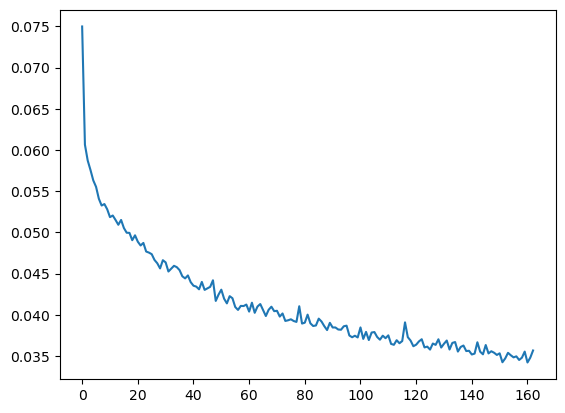

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

losses = pipeline_mlp.named_steps['regressor'].regressor_.loss_curve_
iterations = range(pipeline_mlp.named_steps['regressor'].regressor_.n_iter_)
sns.lineplot(x = iterations, y = losses)